## The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

le = LabelEncoder()

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
%matplotlib inline

# Reading Data

In [2]:
data = pd.read_csv(r"C:\Users\namra\OneDrive\Documents\CubeSmart\Case Study Data.csv")

In [3]:
data.shape

(41188, 21)

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


# Variable Idententification

In [5]:
data.dtypes

age               float64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

We can see there are 10 continuous and 11 categorical variables.

In [6]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,37444.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,36040.000000,41188.000000,41188.000000,41188.000000
mean,39.999947,258.285010,2.567593,962.475454,0.172963,0.081886,93.575575,-40.502600,3.621291,5167.035911
std,10.414908,259.279249,2.770014,186.910907,0.494901,1.570960,0.579216,4.628198,1.734447,72.251528
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
data['y'].value_counts()/len(data.y)

no     0.887346
yes    0.112654
Name: y, dtype: float64

We can see that there is a data imbalance between two classes in the target variable. We need to over/under sample these classes so that we don't get biased results towards a 'no'(since data has 88% no - class)

# Finding missing values

In [8]:
data.replace('unknown',np.NaN,inplace=True)

In [9]:
data.isnull().sum()

age               3744
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx    5148
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

we have 8 columns in total which has null values.

# Univariate analysis of continuous variables

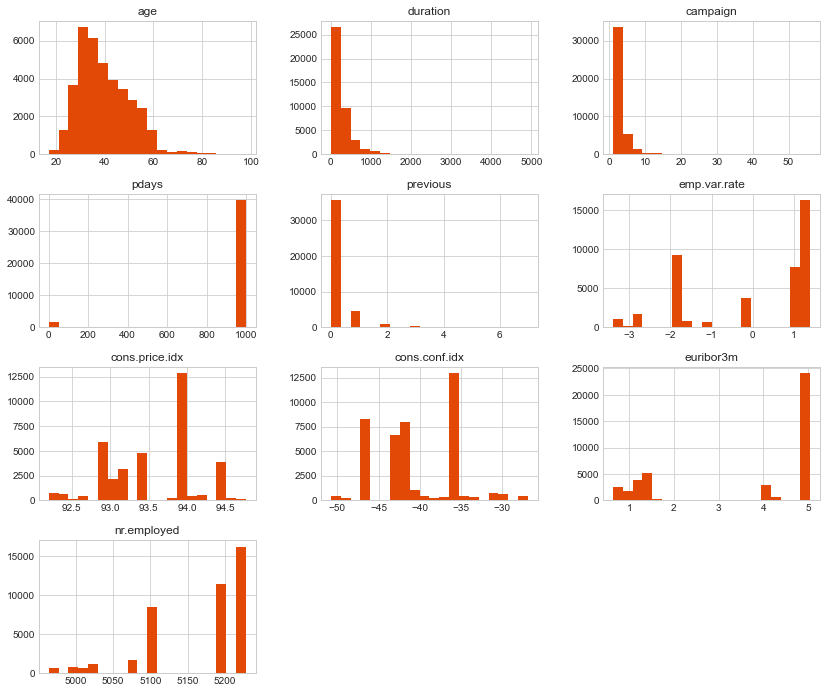

In [10]:
plt.style.use('seaborn-whitegrid')

data.hist(figsize=(14,12),bins=20, color='#E24906')
plt.show()

## Transforming duration,age & campaign attributes as they are more right skewed

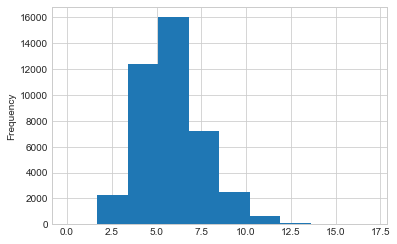

In [11]:
np.power(data['duration'],1/3).plot.hist()
data['duration'] = np.power(data['duration'],1/3)

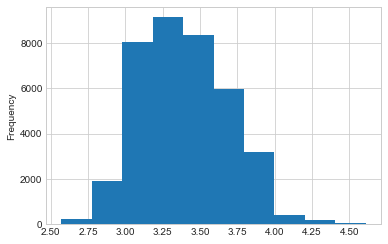

In [12]:
np.power(data['age'],1/3).plot.hist()
data['age'] = np.power(data['age'],1/3)

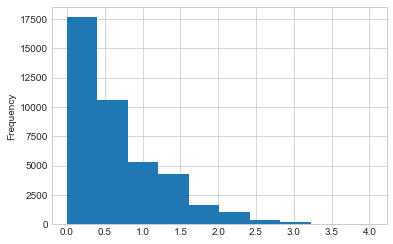

In [13]:
np.log(data['campaign']).plot.hist()
data['campaign'] = np.log(data['campaign'])

# Observing Outliers

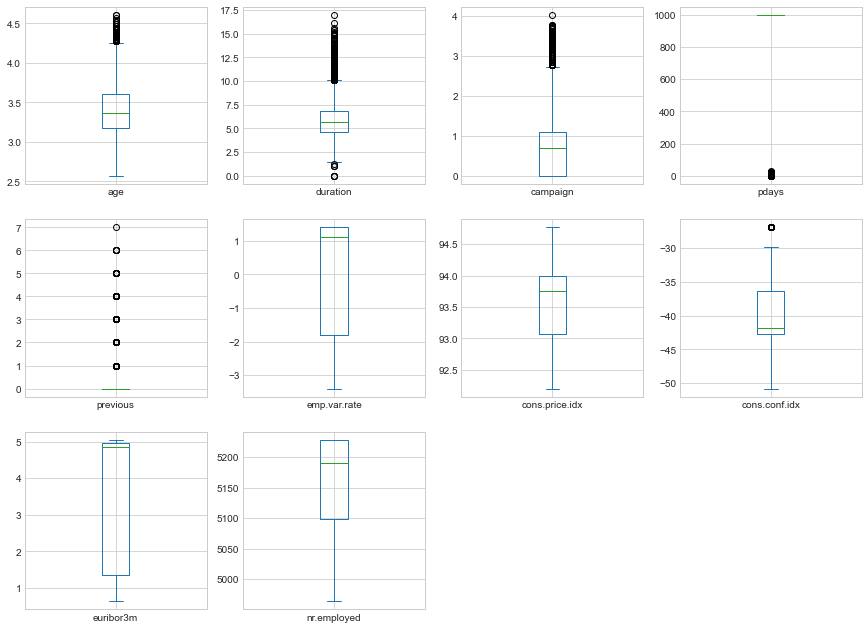

In [14]:
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

# Removing outliers in Age, Duration, Campaign

In [15]:
outliers = ['age','duration','campaign']
for i in outliers:
    Q1=data[i].quantile(0.25)
    Q3=data[i].quantile(0.75)
    IQR=Q3-Q1
    data.loc[data[i]>(Q3+1.5*IQR),i]=np.median(data[i])
    data.loc[data[i]<(Q1-1.5*IQR),i]=np.median(data[i])


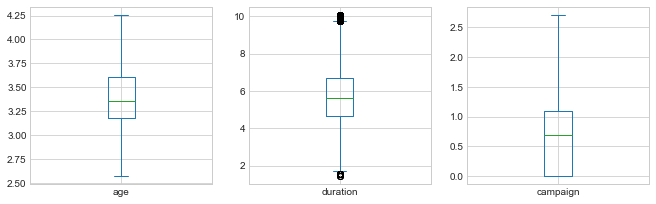

In [16]:
data[outliers].plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

We could see 'emp.var.rate' is positively correlated with 'cons.price.idx' & 'nr.employed' and age does not have any correlation with other numerical variables.

## HeatMap of Numerical Columns

<AxesSubplot:>

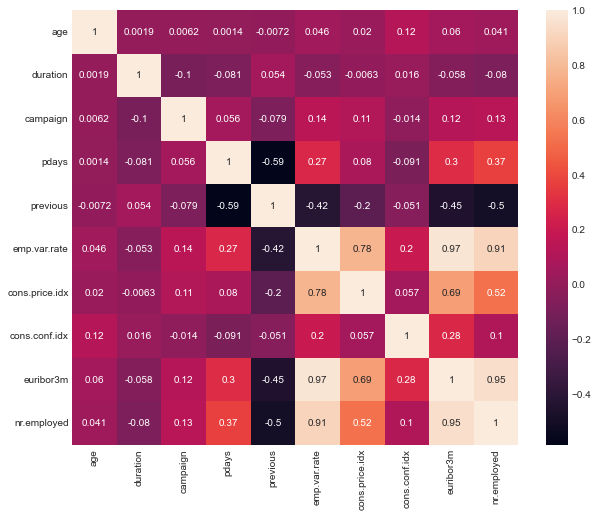

In [18]:
cor=data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True)

"emp.var.rate" variable is highly correlated with 'euribor3m' & 'nr.employed' 
When independent variables are highly correlated, change in one variable would cause change to another and so the model results fluctuate significantly. The model results will be unstable and vary a lot given a small change in the data or model.
So dropping 'emp.var.rate' 

In [19]:
data = data.drop(['emp.var.rate'],axis=1)

# Crosstabs for Categorical Columns

In [20]:
pd.crosstab(data['marital'],data['y'])

y,no,yes
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620


Married person has more odds of subscribing to the term deposit.

In [21]:
pd.crosstab(data['poutcome'],data['day_of_week'])

day_of_week,fri,mon,thu,tue,wed
poutcome,,,,,
failure,903,873,867,805,804
nonexistent,6703,7364,7442,6994,7060
success,221,277,314,291,270


Calls that were made on thursday were more succesfull compared to other days. Also calls made on friday were most unsuccessful

In [22]:
pd.crosstab(data['education'],data['y'])

y,no,yes
education,,
basic.4y,3748,428
basic.6y,2104,188
basic.9y,5572,473
high.school,8484,1031
illiterate,14,4
professional.course,4648,595
university.degree,10498,1670


Person who has university degree is more likely to subscribe to term deposit followed by people having high school education

In [23]:
pd.crosstab(data['job'],data['y'])

y,no,yes
job,,
admin.,9070,1352
blue-collar,8616,638
entrepreneur,1332,124
housemaid,954,106
management,2596,328
retired,1286,434
self-employed,1272,149
services,3646,323
student,600,275


Person who is employed as admin has more odds of subscribing to term deposit followed by technician and blue collar employees

## Imputing Mean values in missing Continuous Variables

In [24]:
mean_age=round(data["age"].mean(),0)
data["age"].fillna(value=mean_age, inplace=True)

mean_value=data["cons.price.idx"].mean()
data["cons.price.idx"].fillna(value=mean_value, inplace=True)

## Using One hot encoding for cols which are categorical, not ordinal and doesn't have missing values

In [25]:
contact_type = pd.get_dummies(data['contact'],drop_first=True)
poutcome_type = pd.get_dummies(data['poutcome'],drop_first=True)

data = data.drop(['contact','poutcome'],axis=1)
data = pd.concat([data,contact_type,poutcome_type],axis=1)

## Predicting Missing Values in Categorical Variables using LGBMClassifier

In [26]:
missing_cols = ['marital','job','loan','housing','education','default']

train = data[[cols for cols in data.columns if cols not in missing_cols]]

for i in missing_cols:
    train = pd.concat([train,data[i]],axis=1)
    test = train[train[i].isnull()]
    test = test.drop(columns = [i], axis=1)
    train =  train[train[i].notnull()]

    # Labelencoding categorical variables that has missing values.
   
    var_mod = train.select_dtypes(include='object').columns
    for j in var_mod:
        train[j] = le.fit_transform(train[j])
        try:
            test[j] = le.transform(test[j])
        except:
            pass
   
    X= train.drop(columns = [i], axis=1)
    y= train[i]
    
    if len(data[[i]].select_dtypes(include='object').columns)==1:
        model=LGBMClassifier()
        model.fit(X,y)
        preds = model.predict_proba(test)

        list_test = []
        for lj,li in enumerate(list(preds)):
            ind = np.where(li==max(li))[0][0]
            list_test.append(ind)

        test[i] = list_test
        train = pd.concat([train,test])   

In [27]:
tes_train = train.drop(['y'], axis = 1)
tes_y = train['y']

In [28]:
tes_train.shape,tes_y.shape

((41188, 20), (41188,))

# Building Models

In [29]:
X_train, X_validation, Y_train, Y_validation = train_test_split(tes_train, tes_y, test_size=0.20, random_state=1)

## Using Synthetic Minority Over-sampling Technique(SMOTE)

In [30]:
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train==0)))

sm = SMOTE(random_state=31)
X_train_res, y_train_res = sm.fit_resample(X_train, Y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 3682
Before OverSampling, counts of label '0': 29268 

After OverSampling, the shape of train_X: (58536, 20)
After OverSampling, the shape of train_y: (58536,) 

After OverSampling, counts of label '1': 29268
After OverSampling, counts of label '0': 29268


# Finding the Column with high priority- Feature Selection

In [31]:
predictors = ['age', 'telephone', 'month', 'day_of_week', 'duration', 'campaign','pdays', 'previous', 'nonexistent','success', 
              'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed', 'marital', 'job', 'loan','housing', 'education', 'default']

random_clf = RandomForestClassifier(n_estimators= 100,random_state=0)
random_clf.fit(X_train_res, y_train_res)
featimp = pd.Series(random_clf.feature_importances_, index=predictors).sort_values(ascending=False)
print (featimp)

day_of_week       0.349624
success           0.119270
cons.price.idx    0.083841
duration          0.069969
age               0.055213
previous          0.042803
cons.conf.idx     0.037579
nonexistent       0.036401
job               0.030370
month             0.027035
education         0.026234
telephone         0.021450
campaign          0.019205
marital           0.014956
nr.employed       0.013831
pdays             0.013667
euribor3m         0.013203
housing           0.013068
loan              0.012260
default           0.000022
dtype: float64


We could see day_of_week has high priority. i.e, calling on particular day of week has high chances that the customer is likely to answer the call & the customer is likely to subscribe to a term deposit. Since default has the least significance, we can drop 'default' variable.

In [32]:
X_train_res = X_train_res.drop(['default'],axis=1)
X_validation = X_validation.drop(['default'],axis=1)

## Building logistic regression Model

In [33]:
parameters = {'C': np.linspace(1, 10, 10)}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(X_train_res, y_train_res.ravel())

print(clf.best_params_.values())

lr1 = LogisticRegression(C=int(sum(clf.best_params_.values())),verbose=5,max_iter=150)
lr1.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
dict_values([4.0])


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


LogisticRegression(C=4, max_iter=150, verbose=5)

In [34]:
y_pre = lr1.predict(X_validation)

cnf_matrix = confusion_matrix(Y_validation, y_pre)
lr1.score(X_validation,Y_validation)

0.8086914299587279

In [35]:
cnf_matrix

array([[5933, 1347],
       [ 229,  729]], dtype=int64)

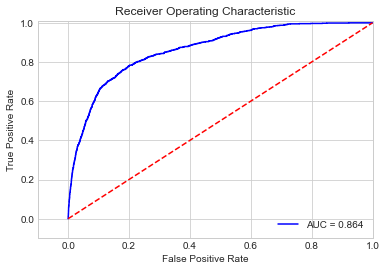

In [36]:
y_pred_sample_score = lr1.decision_function(X_validation)


fpr, tpr, thresholds = roc_curve(Y_validation, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
print(classification_report(Y_validation,y_pre))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      7280
           1       0.35      0.76      0.48       958

    accuracy                           0.81      8238
   macro avg       0.66      0.79      0.68      8238
weighted avg       0.89      0.81      0.84      8238



## Comparing Logistic Regression with other Classifiers

In [38]:
trans = MinMaxScaler()  # normalizing data before feeding it to models.
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
models = [LGBMClassifier,DecisionTreeClassifier,KNeighborsClassifier,RandomForestClassifier,LogisticRegression]
dict_ = {}
for i in models:
    model = i
    results = []
    pipeline = Pipeline(steps=[('t', trans), ('m', model())])
    cart_results = cross_val_score(pipeline, X_train_res, y_train_res, cv=kfold, scoring='accuracy')
    results.append(cart_results)
    cart_results = cart_results.mean()
    dict_[i] = cart_results

In [39]:
dict_

{lightgbm.sklearn.LGBMClassifier: 0.944376143309745,
 sklearn.tree._classes.DecisionTreeClassifier: 0.9200491298865245,
 sklearn.neighbors._classification.KNeighborsClassifier: 0.8831658225313017,
 sklearn.ensemble._forest.RandomForestClassifier: 0.9522516171891795,
 sklearn.linear_model._logistic.LogisticRegression: 0.8340676753563315}

1. After minmax scaling & stratified kfold logistic regression model accuracy is increased from 0.809 to 0.838.
2. Random forest classifier has the highest accuracy = 95.2% followed by LGBMClassifier = 94.5%

## Deliverable Requirements

1. Exploratory data analysis,Data cleaning can be found above & includes:
    a) Finding missing values 
    b) Univariate analysis of continuous variables
    c) Transformations of data that are not normally distributed
    d) Observing Outliers & Removing outliers
    e) Scatter Matrix of Numerical Columns
    f) Crosstabs for Categorical Columns
    g) Imputing Mean values in missing Continuous Variables
    h) Using One hot encoding for cols which are categorical, not ordinal and doesn't have missing values
    i) Predicting Missing Values in Categorical Variables using LGBMClassifier


2. Below tasks are done for better modelling purposes:

   a) Firstly, I've imputed unknown values with np.nan to see how many values are actually missing per attribute.
   b) I've used transformations for duration,age & campaign attributes to transform them to approximately normal distribution.
   c) Removed outliers in Age, Duration, Campaign as they affect the robustness of the model.
   d) Imputed mean values for missing continuous variables so that the spread of data points from mean will be less.
   e) One hot encoding is done for cols which are categorical, not ordinal and doesn't have missing values.
   f) Missing categorical variables are predicted using LGBMClassifier instead of imputing the values with mode.
   g) Used SMOTE technique to over sample the data as the given data is Imbalanced.
   h) Used feataure selection to find column importance and dropped default as it has the least priority.

3. From above accuracies we can see that logistic regression has the least accuracy with 83%. Random classifier model has highest accuracy of 95.2% and LGBM classifier has 94.5% for predicting the data which are almost similar. 
   There are many advantages of using LGBM classifier like:
       a) Faster training speed and higher accuracy
       b) Lower memory usage
       c) Better than any boosting techniques.
   Though, there are many advantages for LGBM Classifier, I'd prefer random forest classifier as the odds of model overfitting the data is less for random forest classifier.

4. I'd suggest 2 USE CASES:
   1) Customer Acquisition : With already existing data, bank should measure campaign effectiveness, potential value of each   customer and personalize the term deposit.
   
   2) Customer Retention: While focusing on new customers, its equally important to maximize customer retention strategy. 
   
   The bank should be focussing more on people who:
    a) Are Married
    b) Are Employed as 'Admin', 'Technician', 'Blue-collar Worker'
    c) Has University degree or High school degree
    
   Calls done on thursday has more success rate which needs to be considered.
   
  

5. Well, I've few questions & requirements of the data to solve it completely.
    1) What's the business purpose of predicting who could subscribe for term deposit?
    2) What is the term deposit duration? Is it different for everyone(customized)?
    3) Have you focussed on retention rate? Was there cases who have discontinued term deposit? If yes, I'd like to look at their data in order to make sure we increase retention period for others who are on almost same page.
    4) What's the highest period of term subscription?